### Intrusion Detection ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_data = pd.read_csv('data\Wednesday-workingHours-pcap_ISCX.csv')
print(df_data.shape)
df_data.head()

<>:1: SyntaxWarning: invalid escape sequence '\W'
<>:1: SyntaxWarning: invalid escape sequence '\W'
C:\Users\arunk\AppData\Local\Temp\ipykernel_20564\3119943531.py:1: SyntaxWarning: invalid escape sequence '\W'
  df_data = pd.read_csv('data\Wednesday-workingHours-pcap_ISCX.csv')


(692703, 85)


,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.14-209.48.71.168-49459-80-6,192.168.10.14,49459,209.48.71.168,80,6,5/7/2017 8:42,38308,1,1,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,192.168.10.3-192.168.10.17-389-49453-6,192.168.10.17,49453,192.168.10.3,389,6,5/7/2017 8:42,479,11,5,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,192.168.10.3-192.168.10.17-88-46124-6,192.168.10.17,46124,192.168.10.3,88,6,5/7/2017 8:42,1095,10,6,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,192.168.10.3-192.168.10.17-389-49454-6,192.168.10.17,49454,192.168.10.3,389,6,5/7/2017 8:42,15206,17,12,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,192.168.10.3-192.168.10.17-88-46126-6,192.168.10.17,46126,192.168.10.3,88,6,5/7/2017 8:42,1092,9,6,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [3]:
df_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       692703 non-null  object 
 1    Source IP                    692703 non-null  object 
 2    Source Port                  692703 non-null  int64  
 3    Destination IP               692703 non-null  object 
 4    Destination Port             692703 non-null  int64  
 5    Protocol                     692703 non-null  int64  
 6    Timestamp                    692703 non-null  object 
 7    Flow Duration                692703 non-null  int64  
 8    Total Fwd Packets            692703 non-null  int64  
 9    Total Backward Packets       692703 non-null  int64  
 10  Total Length of Fwd Packets   692703 non-null  int64  
 11   Total Length of Bwd Packets  692703 non-null  float64
 12   Fwd Packet Length Max        692703 non-nul

In [4]:
# There are 692K records, which we are going to reduce to 200K maintaining the proportion. This will allow for training without extensive compute requirement.
# After creating a sample with 100K records, we will save sample dataframe to a csv file, that might come handy during later phases of model development

output_file = "data\Wednesday-workingHours-pcap_ISCX_processed.csv"  
column_name = "Label"
sample_size = 300000

# Check if the column exists
if column_name not in df_data.columns:
    print(f"Error: Column '{column_name}' not found in the Excel file.")
else:
    # Group the data by the specified column and calculate sampling proportions
    proportions = df_data[column_name].value_counts(normalize=True)
    
    # Sample records while maintaining the proportions
    df_sample = pd.DataFrame()
    for category, proportion in proportions.items():
        n_samples = int(proportion * sample_size)  # Calculate number of samples for each category
        category_sample = df_data[df_data[column_name] == category].sample(n=n_samples, random_state=42)
        df_sample = pd.concat([df_sample, category_sample], ignore_index=True)
    
    # Shuffle the resulting sampled dataframe
    df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

    # Save the sampled data to a new csv data file
    df_sample.to_csv(output_file, index=False)
    print(f"Sampled data saved to '{output_file}'!") 

<>:4: SyntaxWarning: invalid escape sequence '\W'
<>:4: SyntaxWarning: invalid escape sequence '\W'
C:\Users\arunk\AppData\Local\Temp\ipykernel_20564\1016337281.py:4: SyntaxWarning: invalid escape sequence '\W'
  output_file = "data\Wednesday-workingHours-pcap_ISCX_processed.csv"


Sampled data saved to 'data\Wednesday-workingHours-pcap_ISCX_processed.csv'!


In [5]:
# Identify unique values in [Label] column.
unique_values = df_sample['Label'].unique()
print(unique_values)


['BENIGN' 'DoS Hulk' 'DoS Slowhttptest' 'DoS GoldenEye' 'DoS slowloris'
 'Heartbleed']


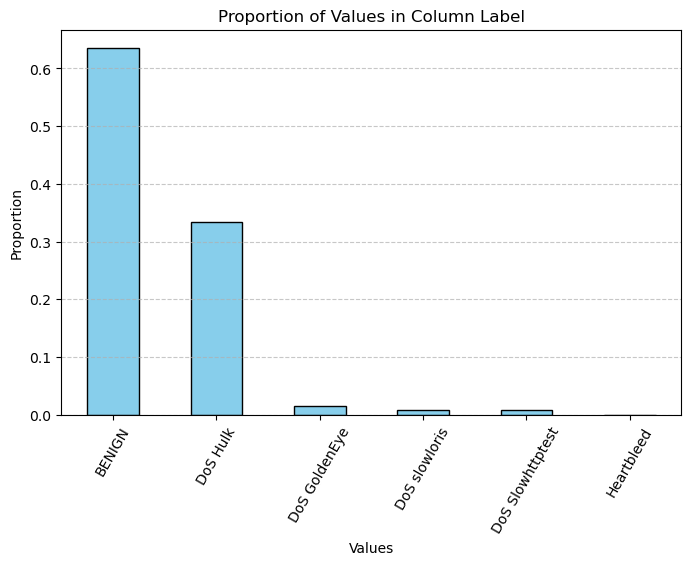

In [6]:
plt.figure(figsize=(8, 5))
proportions.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Proportion of Values in Column Label")
plt.xlabel("Values")
plt.ylabel("Proportion")
plt.xticks(rotation=60)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# Convert [Label] column values into integer with BENIGN being 0 and rest to 1

mapping = {
    "BENIGN": 0,
    "DoS Hulk": 1,
    "DoS GoldenEye": 1,
    "DoS slowloris": 1,
    "DoS Slowhttptest": 1,
    "Heartbleed": 1
}

# Apply mapping to [Label] column
df_sample['Label'] = df_sample['Label'].map(mapping)
unique_values = df_sample['Label'].unique()
print(unique_values)



[0 1]


In [8]:
# Replace 'Infinity' and other string issues with actual np.nan
df_sample.replace(['Infinity', 'NaN', 'nan', 'NaN ', ' NAN'], np.nan, inplace=True)

# Drop columns with all NaNs or a single unique value
df_sample.dropna(axis=1, how='all', inplace=True)
for col in df_sample.columns:
    if df_sample[col].nunique() <= 1:
        df_sample.drop(columns=col, inplace=True)

# Strip whitespace from all column names
df_sample.columns = df_sample.columns.str.strip()

# Drop rows with any missing values
df_sample.dropna(inplace=True)

df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299550 entries, 0 to 299996
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Flow ID                      299550 non-null  object 
 1   Source IP                    299550 non-null  object 
 2   Source Port                  299550 non-null  int64  
 3   Destination IP               299550 non-null  object 
 4   Destination Port             299550 non-null  int64  
 5   Protocol                     299550 non-null  int64  
 6   Timestamp                    299550 non-null  object 
 7   Flow Duration                299550 non-null  int64  
 8   Total Fwd Packets            299550 non-null  int64  
 9   Total Backward Packets       299550 non-null  int64  
 10  Total Length of Fwd Packets  299550 non-null  int64  
 11  Total Length of Bwd Packets  299550 non-null  float64
 12  Fwd Packet Length Max        299550 non-null  int64  
 13  Fwd 

In [9]:
# Converting Source IP and Destination IP columns from object to float. For this we will remove the periods in IP addresses
df_sample['Source IP'] = df_sample['Source IP'].str.replace('.', '').astype(float)
df_sample['Destination IP'] = df_sample['Destination IP'].str.replace('.', '').astype(float)

# Convert [Timestamp] column which is in Object form to float epoch time
df_sample['Timestamp'] = pd.to_datetime(df_sample['Timestamp']).apply(lambda x: x.timestamp())

df_sample[['Timestamp', 'Source IP', 'Destination IP']].head()


,Timestamp,Source IP,Destination IP
0,1.494158e+09,1.921681e+09,1.722171e+08
1,1.494124e+09,6.494116e+09,1.921681e+09
2,1.494154e+09,1.721601e+06,1.921681e+09
3,1.494153e+09,1.721601e+06,1.921681e+09
4,1.494150e+09,1.921681e+08,1.921681e+08


In [10]:
# Dropping Flow ID column as it has no impact on whether the traffic is Benign or Harmful
df_sample = df_sample.drop(columns=['Flow ID'])

In [11]:

# Calculate min, max, and range for each column
min_values = df_sample.min()
max_values = df_sample.max()
range_values = max_values - min_values

summary_df = pd.DataFrame({
    'Min': min_values,
    'Max': max_values,
    'Range': range_values
})

sorted_summary_df = summary_df.sort_values(by='Range', ascending=False)

print("Summary (sorted by Range in descending order):")
print(sorted_summary_df)

Summary (sorted by Range in descending order):
                          Min           Max         Range
Flow Packets/s     -2000000.0           inf           inf
Flow Bytes/s      -12000000.0           inf           inf
Destination IP         8064.0  2.552553e+11  2.552552e+11
Source IP              8601.0  2.221612e+11  2.221612e+11
Subflow Bwd Bytes         0.0  5.934691e+08  5.934691e+08
...                       ...           ...           ...
RST Flag Count            0.0  1.000000e+00  1.000000e+00
SYN Flag Count            0.0  1.000000e+00  1.000000e+00
FIN Flag Count            0.0  1.000000e+00  1.000000e+00
Fwd PSH Flags             0.0  1.000000e+00  1.000000e+00
Label                     0.0  1.000000e+00  1.000000e+00

[74 rows x 3 columns]


In [12]:
# As [Flow Packets/s] and [Flow Bytes/s] have Max value of infinity and range of infinity, we will drop these columns from data set
df_sample = df_sample.drop(columns=['Flow Packets/s', 'Flow Bytes/s'])

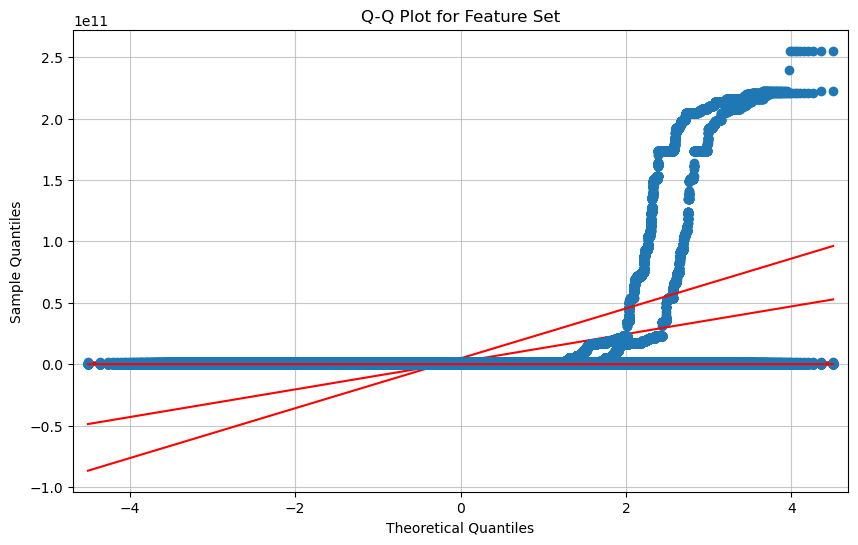

In [13]:
# Creating Q-Q plot for Feature set X to determine data set distribution is Normal or not.
 
plt.figure(figsize=(10, 6))
for column in df_sample.columns:
    sm.qqplot(df_sample[column], line='s', ax=plt.gca(), label=column)

plt.title("Q-Q Plot for Feature Set")
plt.grid(alpha=0.7)
plt.show()


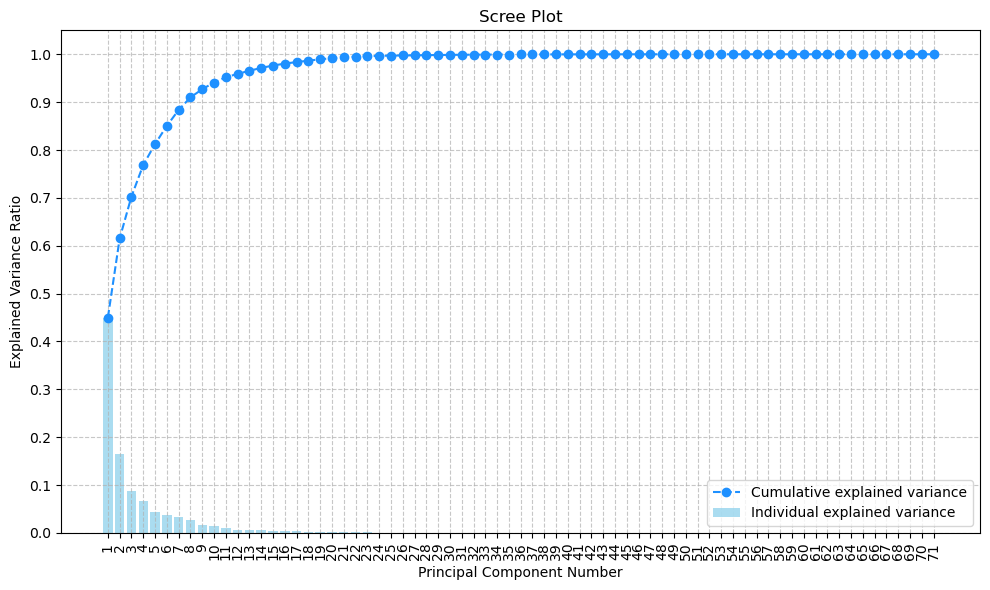

In [14]:
# There are 70+ features that need to be reduced. We will start with doing Principal Component Analysis(PCA) to reduce features based on >90% variance explanation
# Creating a dataframe without the target column [Label]

features = df_sample.drop(columns=['Label'])
target = df_sample['Label']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Perform PCA
# By default, PCA will compute as many components as there are features
pca = PCA()
pca.fit_transform(scaled_features)

# Get the explained variance ratio
# This tells us the proportion of the dataset's variance that lies along each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Number of components
n_components = len(explained_variance_ratio)
component_numbers = np.arange(1, n_components + 1)

# Create the scree plot
plt.figure(figsize=(10, 6))

# Plot the explained variance for each component (the "scree")
plt.bar(component_numbers, explained_variance_ratio, alpha=0.7, align='center',
        label='Individual explained variance', color='skyblue')

# Plot the cumulative explained variance
plt.plot(component_numbers, cumulative_explained_variance, marker='o', linestyle='--',
            color='dodgerblue', label='Cumulative explained variance')

# Add labels and title
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(component_numbers) # Ensure all component numbers are shown as ticks
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1)) # Set y-axis ticks from 0 to 1 in steps of 0.1
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()



In [15]:
# 10 principal components are explaining around 95% variance so going in with 10 as number of components
pca = PCA(n_components=10)  # reducing to 10 principal components
pca_data = pca.fit_transform(scaled_features)

df_pca = pd.DataFrame(pca_data)
df_pca['Label'] = df_sample['Label']

print("\nPrincipal Components DataFrame:")
print(df_pca)

explained_variance = pca.explained_variance_ratio_
print("\nExplained Variance Ratio:")
print(explained_variance)

cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("\nExplained Cumulative Variance Ratio:")
print(cumulative_explained_variance)



Principal Components DataFrame:
               0         1         2         3         4         5         6  \
0       0.445844 -0.893807  0.949563 -0.215609 -0.254679  0.442317 -0.409710   
1      -0.683772  0.863483  0.280634 -0.506584 -0.099302 -0.459894 -0.015499   
2      -0.519782  0.537598 -0.025748  0.283216  0.100011  0.482670 -0.172673   
3      -0.359313  0.751986  0.195423  0.086751  0.437331 -0.158334 -0.244040   
4      -0.677902 -0.343238 -0.502135  0.168844  0.048043  0.067442 -0.040724   
...          ...       ...       ...       ...       ...       ...       ...   
299545 -0.588264 -0.627692  0.663787  0.259331  0.204951  0.170325 -0.015379   
299546  1.812502 -0.594367 -0.357796 -0.625991  0.438507  0.107154  0.127360   
299547 -0.760638 -0.339262 -0.475947 -0.008576 -0.242600 -0.251922  0.044933   
299548  0.356567 -0.944439  0.818954 -0.306670 -0.641566  0.219624 -0.327053   
299549 -0.542060 -0.711551  0.703788  0.260605 -0.053861 -0.213291  0.198555   

      

In [16]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 299550 entries, 0 to 299996
Data columns (total 72 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Source IP                    299550 non-null  float64
 1   Source Port                  299550 non-null  int64  
 2   Destination IP               299550 non-null  float64
 3   Destination Port             299550 non-null  int64  
 4   Protocol                     299550 non-null  int64  
 5   Timestamp                    299550 non-null  float64
 6   Flow Duration                299550 non-null  int64  
 7   Total Fwd Packets            299550 non-null  int64  
 8   Total Backward Packets       299550 non-null  int64  
 9   Total Length of Fwd Packets  299550 non-null  int64  
 10  Total Length of Bwd Packets  299550 non-null  float64
 11  Fwd Packet Length Max        299550 non-null  int64  
 12  Fwd Packet Length Min        299550 non-null  int64  
 13  Fwd 

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     38153
           1       0.98      0.98      0.98     21757

    accuracy                           0.99     59910
   macro avg       0.98      0.99      0.98     59910
weighted avg       0.99      0.99      0.99     59910



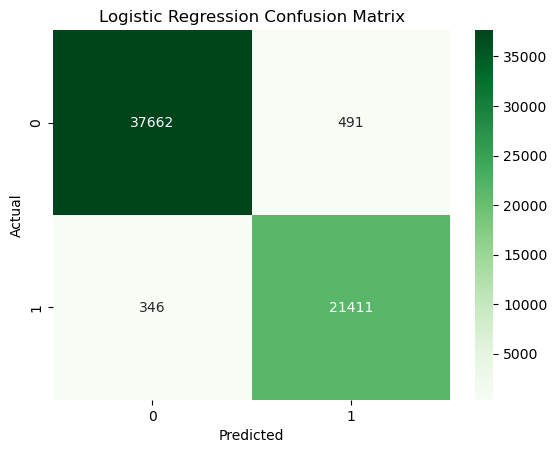

Logistic Regression ROC AUC Score: 0.9987


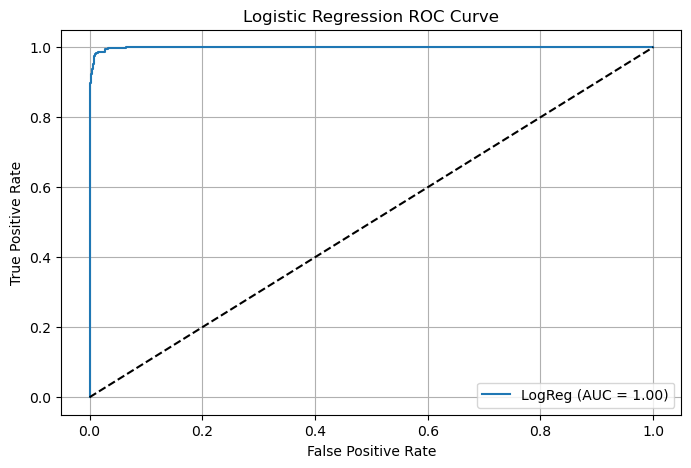

In [17]:
# #Test train split
X = df_sample.drop(columns=['Label'])
y = df_sample['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression
model_lr = LogisticRegression(max_iter=1000, random_state=42)
model_lr.fit(X_train_scaled, y_train)

# Predictions
y_pred_model_lr = model_lr.predict(X_test_scaled)
y_proba_model_lr = model_lr.predict_proba(X_test_scaled)[:, 1]

# Classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_model_lr))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_model_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC
roc_auc_model_lr = roc_auc_score(y_test, y_proba_model_lr)
print("Logistic Regression ROC AUC Score:", round(roc_auc_model_lr, 4))

# ROC Curve
fpr_model_lr, tpr_model_lr, _ = roc_curve(y_test, y_proba_model_lr)
plt.figure(figsize=(8, 5))
plt.plot(fpr_model_lr, tpr_model_lr, label=f'LogReg (AUC = {roc_auc_model_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Logistic Regression ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

Best Logistic Regression Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38153
           1       1.00      1.00      1.00     21757

    accuracy                           1.00     59910
   macro avg       1.00      1.00      1.00     59910
weighted avg       1.00      1.00      1.00     59910

Best F1 Score (CV): 0.9997994809409938


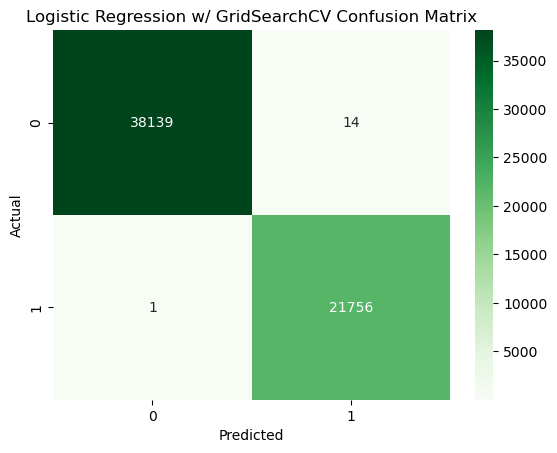

Logistic Regression w/ GridSearchCV ROC AUC Score: 1.0


In [18]:
#Logistic Regression with GridSearchCV

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=500), param_grid_lr, scoring='f1', cv=5)
grid_lr.fit(X_train_scaled, y_train)
y_pred_grid_lr = grid_lr.predict(X_test_scaled)
y_proba_grid_lr = grid_lr.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Best Logistic Regression Params:", grid_lr.best_params_)
print(classification_report(y_test, y_pred_grid_lr))
print("Best F1 Score (CV):", grid_lr.best_score_)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_grid_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Logistic Regression w/ GridSearchCV Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC
roc_auc_grid_lr = roc_auc_score(y_test, y_proba_grid_lr)
print("Logistic Regression w/ GridSearchCV ROC AUC Score:", round(roc_auc_grid_lr, 4))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38153
           1       1.00      1.00      1.00     21757

    accuracy                           1.00     59910
   macro avg       1.00      1.00      1.00     59910
weighted avg       1.00      1.00      1.00     59910



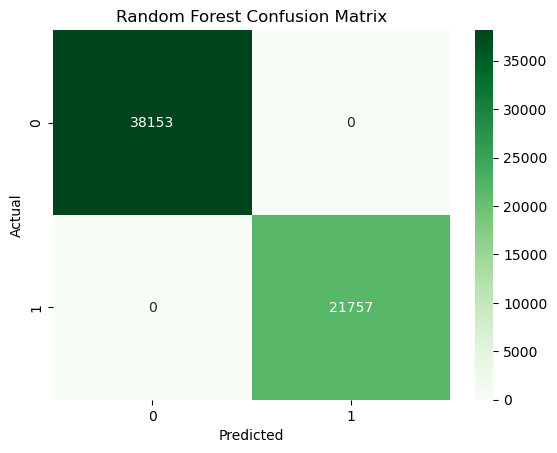

Random Forest ROC AUC Score: 1.0


In [19]:
#Random forest classifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_proba_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)
print("Random Forest ROC AUC Score:", round(roc_auc_rf, 4))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     38153
           1       1.00      1.00      1.00     21757

    accuracy                           1.00     59910
   macro avg       1.00      1.00      1.00     59910
weighted avg       1.00      1.00      1.00     59910



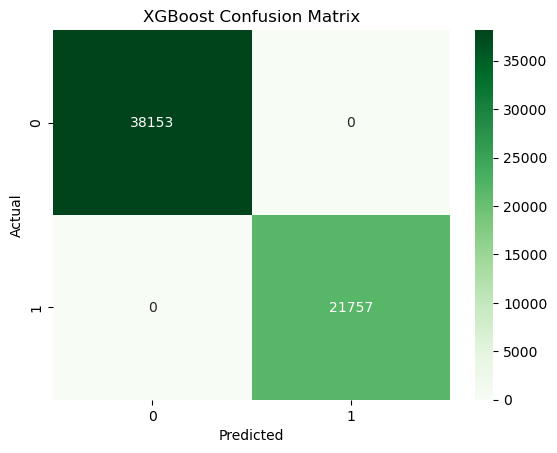

XGBoost ROC AUC Score: 1.0


In [20]:
# XGBoost for a BInary Classification problem as either record will be Benign or Not.

xg = xgb.XGBClassifier(objective='binary:logistic',
                            n_estimators=100,
                            learning_rate=0.1,
                            max_depth=3,
                            subsample=0.8,
                            colsample_bytree=0.8,
                            eval_metric='logloss', # Silences a warning for binary classification
                            random_state=42)

xg.fit(X_train_scaled, y_train)
y_pred_xg = xg.predict(X_test_scaled)
y_proba_xg = xg.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xg))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC AUC
roc_auc_xg = roc_auc_score(y_test, y_proba_xg)
print("XGBoost ROC AUC Score:", round(roc_auc_xg, 4))

In [21]:
import joblib # For saving and loading the model
from flask import Flask, request, render_template, jsonify
import os

#Train and Save the XGBoost Model as XGBoost has best performance scores
# Checks if the 'models' directory exists (if not then create directory) and save model
if not os.path.exists('models'):
    os.makedirs('models')
model_filename = 'models/xgboost_classifier.joblib'
joblib.dump(xg, model_filename)
print(f"Model saved as {model_filename}")

Model saved as models/xgboost_classifier.joblib
